This notebook takes borehole data and SNMR data from the East Kimberley and creates a map of water tables.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import geopandas as gpd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from datetime import datetime
import matplotlib.pyplot as plt
import os, sys
import sqlalchemy as db
from sqlalchemy import create_engine, event
import yaml
import rasterio
from rasterio import Affine
from rasterio.warp import reproject, Resampling
import warnings
import math
warnings.filterwarnings("ignore",category =RuntimeWarning)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


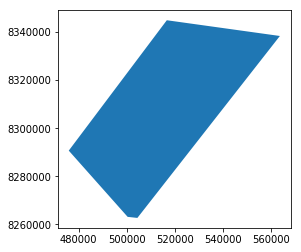

In [3]:
# First we bring in polygons for the area we want to examine

gdf = gpd.read_file(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")

# Visualise the palaeovalley extent as defined by the magnetics
gdf.loc[[2],'geometry'].plot()

# Create a unary union so we can query our spatially query the bores
#OrdKeep = gdf.geometry.unary_union.wkt
OrdKeep = gdf['geometry'].iloc[2].wkt


In [4]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [5]:
# Custom query so we can join on the standing water level table

query = """

select
   b.borehole_id,
   b.Borehole_name,
   b.Easting,
   b.Northing,
   b.Ground_elevation_mAHD,
   swl.Date,
   swl.Depth

from

   borehole b
   left join standing_water_level  swl on b.borehole_id = swl.borehole_id
   
where

   within(b.geom,GeomFromText('{}'))
   
and

   b.SWL_available = 1;""".format(OrdKeep)


df_swl = pd.read_sql(query, connection)

# Rename the depth column
df_swl = df_swl.rename(columns = {"Depth": "SWL_depth"})

In [6]:
# Extract the borehole ids into an array

enos = df_swl['borehole_id'].unique()


In [7]:
# Find the days since the measurement was taken
date_format = "%Y-%m-%d"
today = datetime.now()
days_ago= [(today - datetime.strptime(x, date_format)).days for x in df_swl['Date']]
df_swl['days_since_swl'] = days_ago


In [8]:
# For duplicate entries we will drop the measurements that were taken longer ago

# Minimum indices will be added to a list
min_ind = []

for item in enos:
    # Get the subset
    df_subset = borehole_utils.extract_by_primary_key(df_swl,
                                                     [item])
    min_ind.append(df_subset['days_since_swl'].argmin())

# Filter
df_swl = df_swl.loc[min_ind,:] 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  # Remove the CWD from sys.path while we load stuff.


In [9]:
# Drop the pesky artesian well

df_swl = df_swl[df_swl["SWL_depth"] > 0.]

In [21]:
# Create a water level elevation column

df_swl['wl_mAHD'] = df_swl['Ground_elevation_mAHD'] - df_swl['SWL_depth']

utm_zone = 52
48 points in UTM bounding box: [481885.0, 8274026.4, 542732.935, 8333350.0]


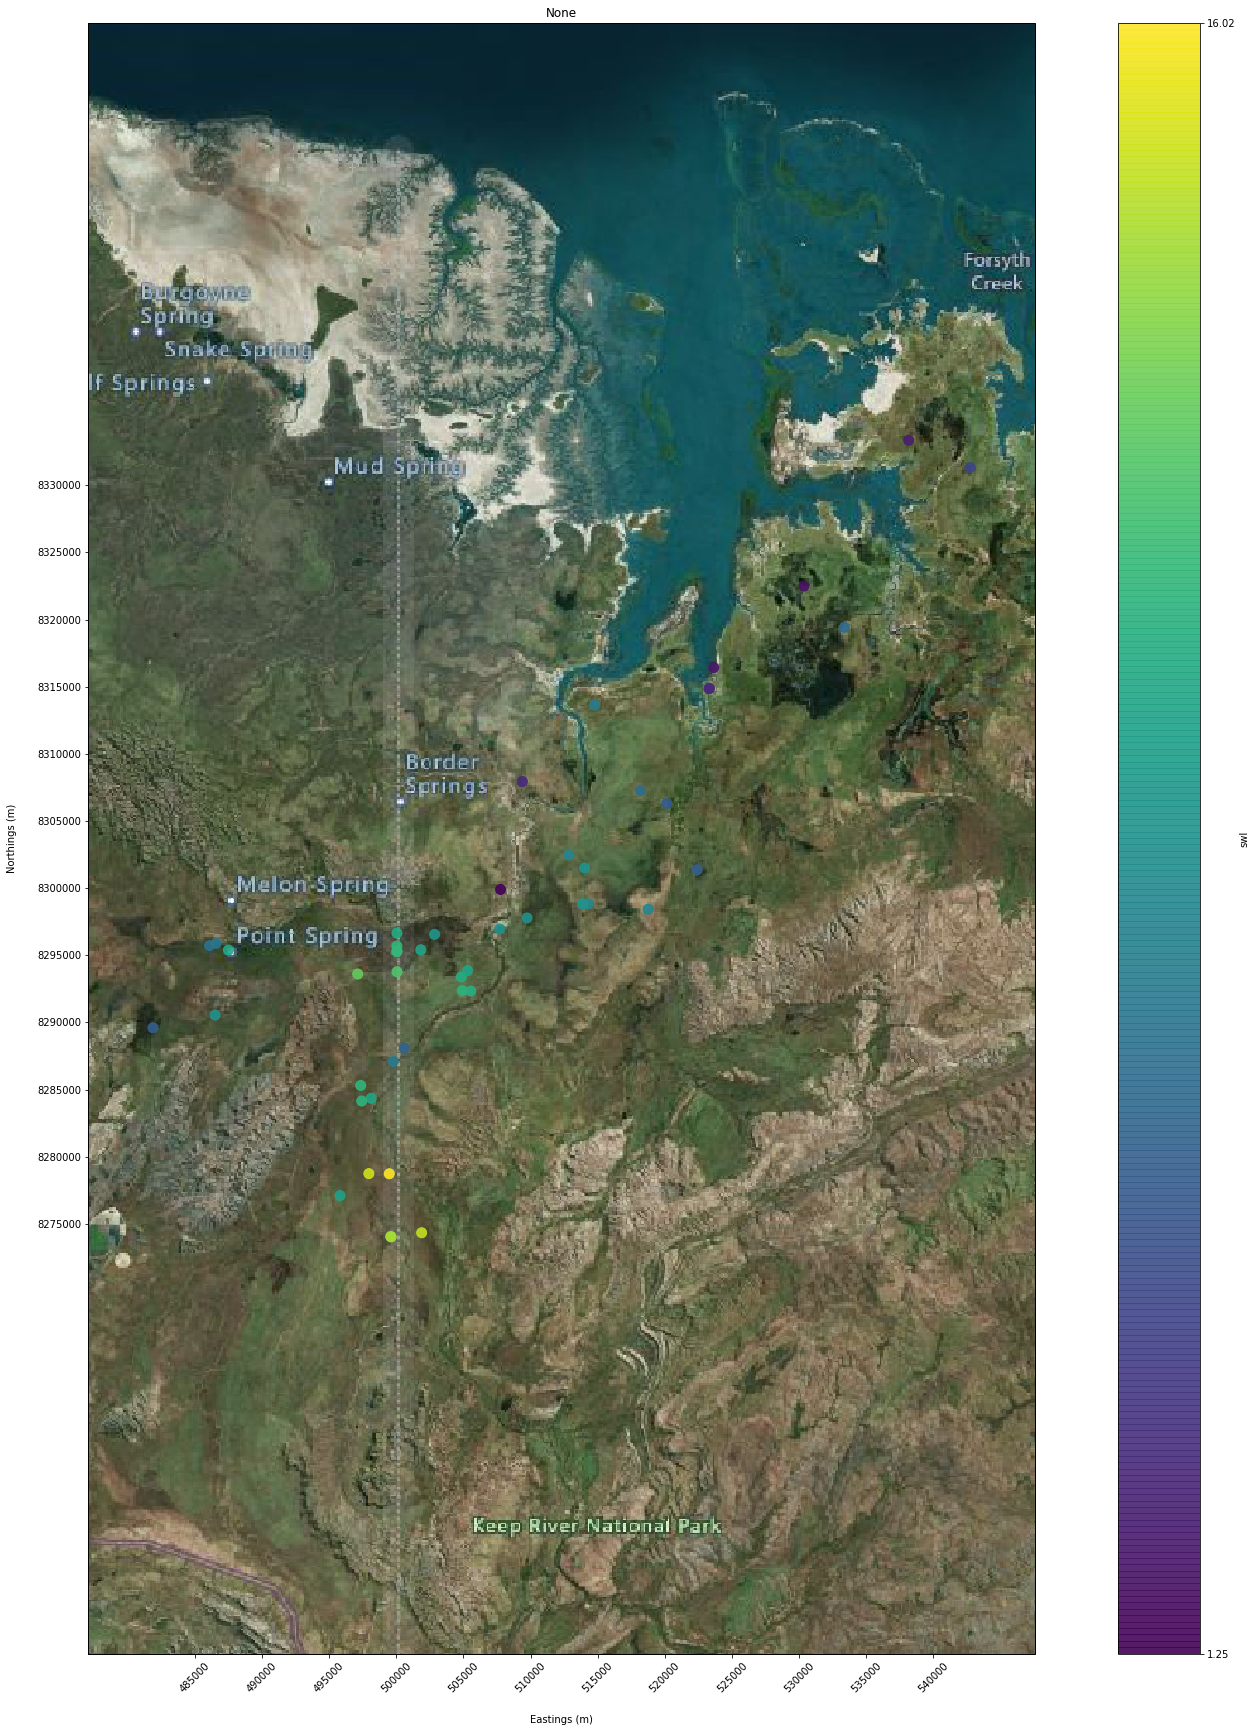

In [11]:
# Plot the bores on a basemap to get an idea of what datasets are available

bore_coords = df_swl[['Easting', 'Northing']].values


swl = df_swl["SWL_depth"].values
#wl_mAHD = df_swl["SWL_depth"].values

plotting_utils.plot_point_dataset(bore_coords, "EPSG:28352", swl, 
                   colourbar_label = 'swl', colour_scheme = 'viridis',
                    point_size=100)


In [12]:
# WE trial anumber of models to find which will fit the best

import numpy as np
from pykrige.rk import Krige
from pykrige.compat import GridSearchCV

# From https://pykrige.readthedocs.io/en/latest/examples/krige_cv.html#sphx-glr-examples-krige-cv-py

# 2D Kring param opt

param_dict = {"method": ["ordinary", "universal"],
              "variogram_model": ["linear", "power", "gaussian", "spherical"],
               "nlags": [4, 6, 8],
               "weight": [True, False]
              }

estimator = GridSearchCV(Krige(), param_dict, verbose=True,
                        scoring = 'explained_variance')

# data
X = bore_coords
y = swl

# run the gridsearch
estimator.fit(X=X, y=y)


if hasattr(estimator, 'best_score_'):
    print('best_score variance explained = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)

print('\nCV results::')
if hasattr(estimator, 'cv_results_'):
    for key in ['mean_test_score', 'mean_train_score',
                'param_method', 'param_variogram_model']:
        print(' - {} : {}'.format(key, estimator.cv_results_[key]))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points wil

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    6.5s finished
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'power' Variogram Model
Scale: 1.392206127217699e-05
Exponent: 1.3335140079275316
Nugget: 3.6614009116091344 



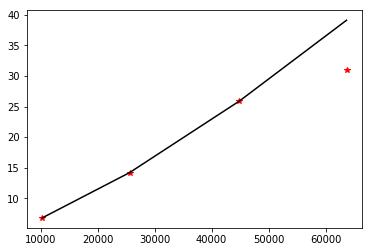

Calculating statistics on variogram model fit...
Q1 = 0.07704477828334703
Q2 = 0.928365103672162
cR = 5.854883535502295 

Initializing drift terms...
Implementing regional linear drift.
Executing Universal Kriging...



In [16]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

X = bore_coords[:,0]
Y = bore_coords[:,1]

# Define grid
gridx = np.arange((math.floor(X.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(X.max() / 10.0)) * 10 + 1000., 50)

gridy = np.arange((math.floor(Y.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(Y.max() / 10.0)) * 10 + 1000., 50)[::-1]

# Create the ordinary kriging object

#OK = OrdinaryKriging(X, Y, swl, variogram_model='power',
#                     verbose=True, enable_plotting=True)

UK = UniversalKriging(X, Y, swl, variogram_model='power',
                      drift_terms=['regional_linear'],
                      nlags = 4, weight = True,
                     verbose=True, enable_plotting=True)

# Creates the kriged grid and the variance grid
#z, ss = OK.execute('grid', gridx, gridy)
z, ss = UK.execute('grid', gridx, gridy)

# Writes the kriged grid to an ASCII grid file.
#kt.write_asc_grid(gridx, gridy, z, filename=r"C:\temp\output.asc")



In [69]:
# Create a mask for points with a variance of 
# greater than 20

mask = ss.data > 20.

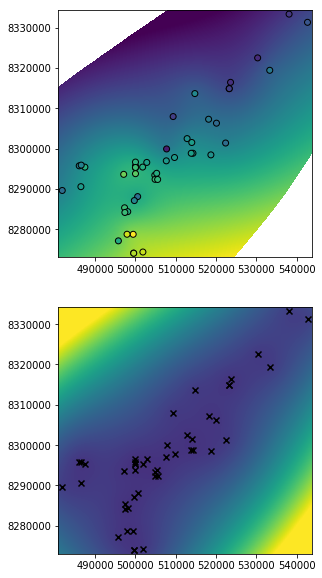

In [70]:
# plot the results
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (40,10))

# Mask the array
swl_results = np.copy(z.data)

swl_results[mask] = np.nan

ax1.imshow(swl_results, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0., vmax = 16.)

ax2.imshow(ss.data, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0, vmax = 30.)

ax1.scatter(X,Y, c = swl, vmin = 0, vmax = 16., edgecolors = 'k')
ax2.scatter(X,Y,marker = 'x', color = 'k', linewidths = 0.1)

plt.show()

In [11]:
# Here we trial regression kriging

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1)
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



# we will use the ground elevation herre as well
p = df_swl['Ground_elevation_mAHD'].values.reshape([-1,1])
x = bore_coords
target = wl_mAHD

# Iterate through the models

for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    
    regression_score = []
    rv_score = []
    var_explained_score = []
    
    # Run 100 times to prevent effects from the random split
    for i in range(200):
        p_train, p_test, x_train, x_test, target_train, target_test \
            = train_test_split(p, x, target, test_size=0.3, random_state=i)
    
    
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10,
                            method='ordinary',variogram_model='power')
        m_rk.fit(p_train, x_train, target_train)
        
        regression_score.append(m_rk.regression_model.score(p_test, target_test))
        rv_score.append(m_rk.score(p_test, x_test, target_test))
        var_explained_score.append(explained_variance_score(m_rk.predict(p_test, x_test), target_test))
        
    print('Regression Score: ', np.mean(regression_score))
    print('RK score: ', np.mean(rv_score))
    print('Variance explained score: ', np.mean(var_explained_score))

regression model: SVR
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished krig

Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Regression Score:  0.27888256088817676
RK score:  0.30280270780350355
Variance explained score:  0.11296312046839475
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finishe

Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished

In [12]:
# Create a new grid
X = bore_coords[:,0]
Y = bore_coords[:,1]

# Define grid
gridx = np.arange((math.floor(X.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(X.max() / 10.0)) * 10 + 1000., 50)

gridy = np.arange((math.floor(Y.min() / 10.0)) * 10 - 1000.,
                  (math.ceil(Y.max() / 10.0)) * 10 + 1000., 50)[::-1]

# Define input file
tif_file = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\LiDAR\LiDAR_final\EK_LiDAR_cubic_10x10.tif'

# Create the new grid

outfile = r"C:\temp\lidar_elev_50m.tif"

spatial_functions.resample_raster(tif_file, outfile, gridx, gridy, driver='GTiff',
                 null = -9999)

In [17]:
src = rasterio.open(outfile)

# Iterator yielding the nearest neighbour
vals = src.sample(bore_coords)

# Add the 50 m grid elevation to the dataframe
df_swl['lid50m_elevation_mAHD'] = np.nan

for index, row in df_swl.iterrows():

    df_swl.at[index, 'lid50m_elevation_mAHD'] = next(vals)[0]

In [32]:
# Drop rows with no lidar elevation, they are not useful to us

df_swl = df_swl[~np.isnan(df_swl['lid50m_elevation_mAHD'])]

In [33]:
df_swl

,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Date,SWL_depth,days_since_swl,lid50m_elevation_mAHD,wl_mAHD
1,626981,RN029663,509738.000,8297777.000,14.936,2016-10-19,8.635,891,14.849471,6.301
3,626984,RN034821,514784.000,8313635.000,12.281,2017-10-07,7.450,538,12.148163,4.831
5,626986,RN029660,500047.884,8295266.378,19.217,2016-10-18,11.290,892,19.119029,7.927
7,626987,RN029665,512860.000,8302461.000,11.873,2016-10-20,7.975,890,11.985136,3.898
9,626988,RN029653,514021.000,8301501.000,12.904,2016-10-20,8.825,890,12.900905,4.079
10,626989,RN029656,504845.000,8293381.000,17.650,2016-10-20,10.430,890,17.520233,7.220
12,626990,RN029666,518194.000,8307268.000,9.266,2016-10-19,6.460,891,9.333680,2.806
14,626991,RN029662,500590.000,8288080.000,18.952,2017-09-30,5.820,545,18.973789,13.132
17,626992,RN030826,501892.000,8274331.000,28.793,2017-10-01,14.660,544,28.846032,14.133
19,635728,RN040873,520144.760,8306293.880,7.519,2018-11-11,5.440,138,8.340292,2.079


In [47]:
# Now lets try runnning a linear regression on these values by building a model
# to estimate water table elevation from from groundelevation

# As above we will use a linear model

from sklearn.linear_model import Ridge
from pykrige.rk import RegressionKriging
from pykrige.compat import GridSearchCV
from pykrige.compat import train_test_split
from sklearn.metrics import explained_variance_score


m = Ridge(alpha = .1,normalize=True,
                 copy_X=True, fit_intercept=False)


m_rk = RegressionKriging(regression_model=m, n_closest_points=10,
                            method='ordinary',variogram_model='power')

# Define model variables
p = df_swl['lid50m_elevation_mAHD'].values.reshape([-1,1])
x = df_swl[['Easting', 'Northing']].values
target = df_swl['wl_mAHD'].values


regression_var_explained = 0
regression_kriging_score = 0.


# We run 100 models
for i in range(100):
    p_train, p_test, x_train, x_test, target_train, target_test \
                = train_test_split(p, x, target,
                                   test_size=0.3, 
                                   random_state=i)


    m_rk.fit(p_train, x_train, target_train)
            
    regression_kriging_score += (m_rk.regression_model.score(p_test, target_test))
    
    regression_var_explained += explained_variance_score(m_rk.predict(p_test, x_test), target_test)
        



Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

In [ ]:
# Cross validation attempt



In [48]:
print('RK score: ', np.sum(regression_kriging_score)/i)
print('Variance explained score: ', np.sum(regression_var_explained)/i)

RK score:  0.6400544115964825
Variance explained score:  0.5430237443736714


In [126]:
# Now train the model on all the data
m_rk.fit(p, x, target)


Finished learning regression model
Finished kriging residuals


In [109]:
# Now lets predict our model

xv, yv = np.meshgrid(gridx, gridy)

elevations = src.read()[0]

# Do some processing to remove bad values
elevations[elevations < -900] = np.nan

# Create an empty array into which to save our 
# predicted values

predicted = np.nan*np.ones(shape = vals.shape, dtype = vals.dtype)

mask = np.isfinite(elevations)

predict_coords = np.hstack((xv[mask].reshape([-1,1]),
                            yv[mask].reshape([-1,1])))



elev_masked = elevations[mask].reshape([-1,1])

In [127]:
# Predict using regression kriging
pred = m_rk.predict(elev_masked, predict_coords)  

In [128]:
# Now find the variance explained by the model

print('Variance explained score: ', explained_variance_score(m_rk.predict(p, x), target))

Variance explained score:  1.0


In [129]:
# Update the predicted grid values using our mask
predicted[mask] = pred

# REshape the grid back to 2 dimensions
grid = predicted.reshape(elevations.shape)

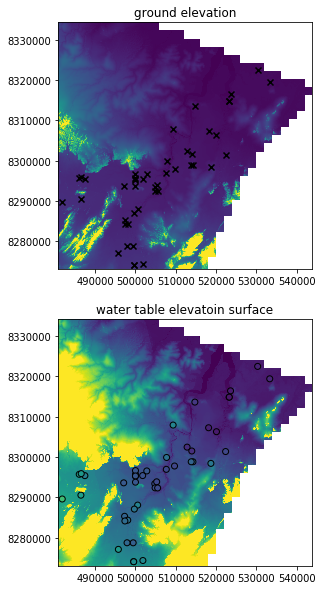

In [130]:
# plot the results
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (40,10))

# Mask the array


ax1.imshow(elevations, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0., vmax = 200.)

ax2.imshow(grid, extent = [gridx[0], gridx[-1], gridy[-1], gridy[0]],
         vmin = 0, vmax = 30.)

# Add bores to the diagrams

X = x[:,0]
Y = x[:,1]

# Scatter with the same colourscheme as the grids
ax2.scatter(X,Y, c = target, vmin = 0, vmax = 30., edgecolors = 'k')
ax1.scatter(X,Y,marker = 'x', color = 'k', linewidths = 0.1)

ax1.set_title("ground elevation")
ax2.set_title("water table elevatoin surface")
plt.show()

In [120]:
# SCatter the final results




,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Date,SWL_depth,days_since_swl,lid50m_elevation_mAHD,wl_mAHD
1,626981,RN029663,509738.000,8297777.000,14.936,2016-10-19,8.635,891,14.849471,6.301
3,626984,RN034821,514784.000,8313635.000,12.281,2017-10-07,7.450,538,12.148163,4.831
5,626986,RN029660,500047.884,8295266.378,19.217,2016-10-18,11.290,892,19.119029,7.927
7,626987,RN029665,512860.000,8302461.000,11.873,2016-10-20,7.975,890,11.985136,3.898
9,626988,RN029653,514021.000,8301501.000,12.904,2016-10-20,8.825,890,12.900905,4.079
10,626989,RN029656,504845.000,8293381.000,17.650,2016-10-20,10.430,890,17.520233,7.220
12,626990,RN029666,518194.000,8307268.000,9.266,2016-10-19,6.460,891,9.333680,2.806
14,626991,RN029662,500590.000,8288080.000,18.952,2017-09-30,5.820,545,18.973789,13.132
17,626992,RN030826,501892.000,8274331.000,28.793,2017-10-01,14.660,544,28.846032,14.133
19,635728,RN040873,520144.760,8306293.880,7.519,2018-11-11,5.440,138,8.340292,2.079


In [12]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\NMR\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"

and

            within(s.geom,GeomFromText('{}'));""".format(OrdKeep)

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = 'FID',
                                 pulse_length_criteria="min")]



In [13]:
# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_inversions = df_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True, )


In [14]:
# Now we want to discover any colocated sites

SNMR_coords = df_acquisitions[['mid_X', 'mid_Y']].values

distances, indices = spatial_functions.nearest_neighbours(bore_coords,
                                                         SNMR_coords,
                                                         points_required = 1,
                                                         max_distance = 200.)


In [15]:
df_swl['co-located_SNMR_site_id'] = -999

# Iterate through the bores and if a site was returned
# add the site id to the dataframe
for i, (index, row)  in enumerate(df_swl.iterrows()):
    idx = indices[i]
    if idx != len(df_acquisitions):
        # Sincve we only have one acquisition per site we can use site_id
        df_swl.at[index, 'co-located_SNMR_site_id'] = df_acquisitions['site_id'].iloc[idx]

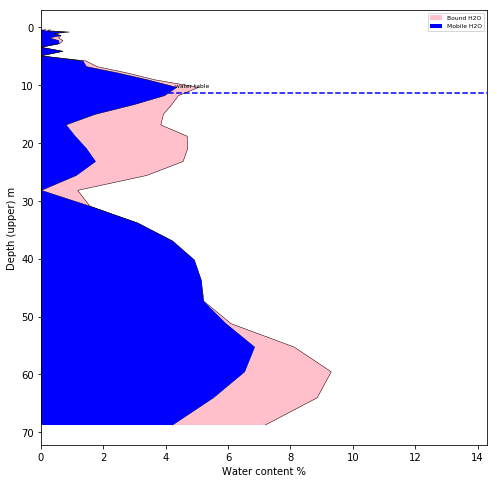

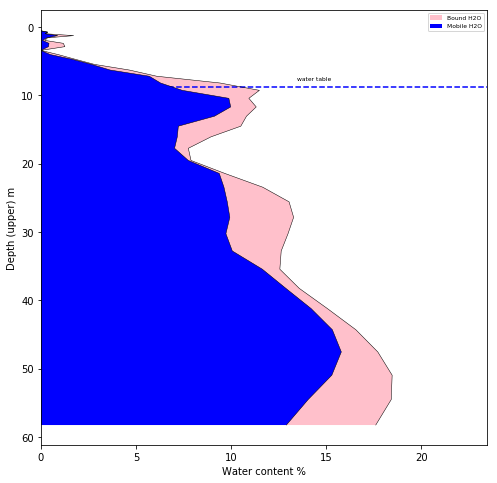

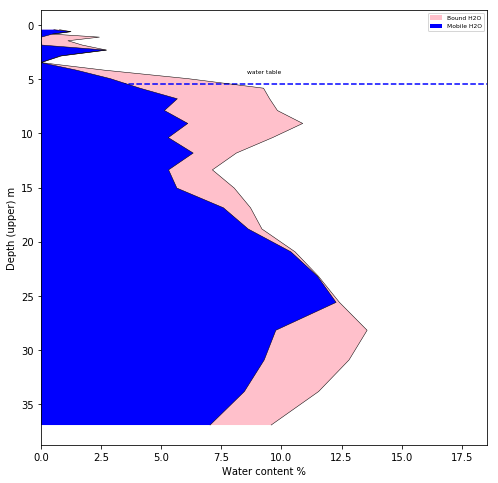

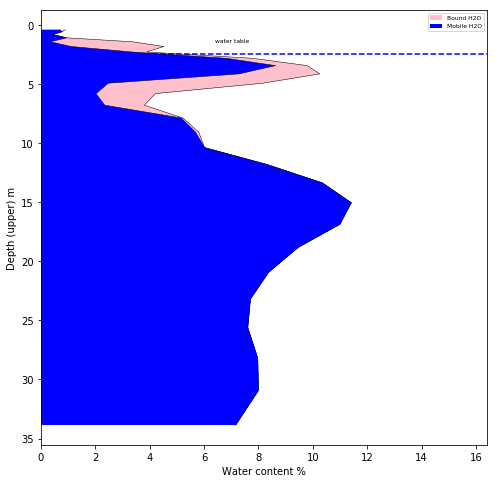

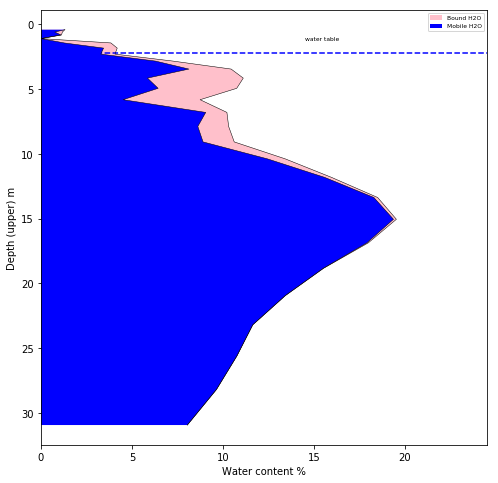

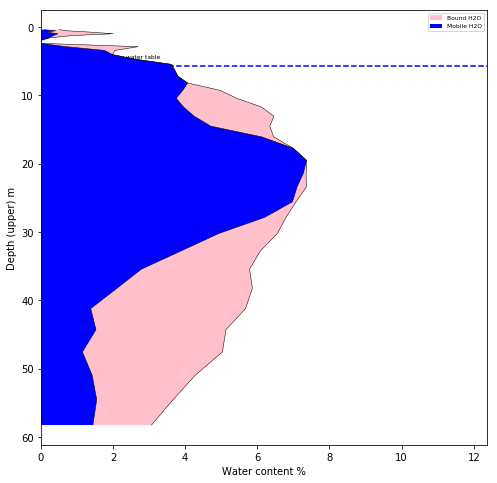

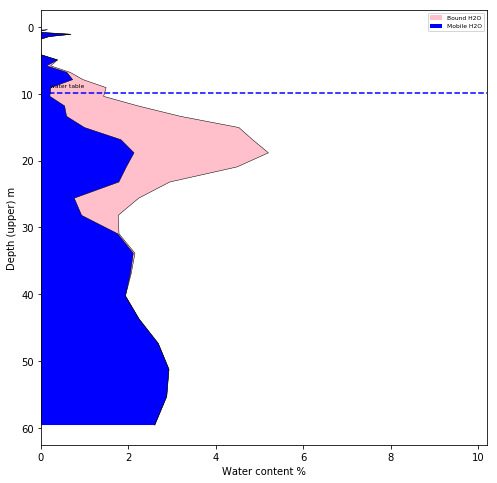

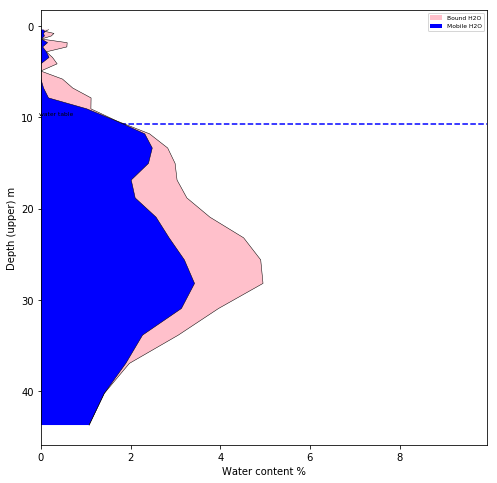

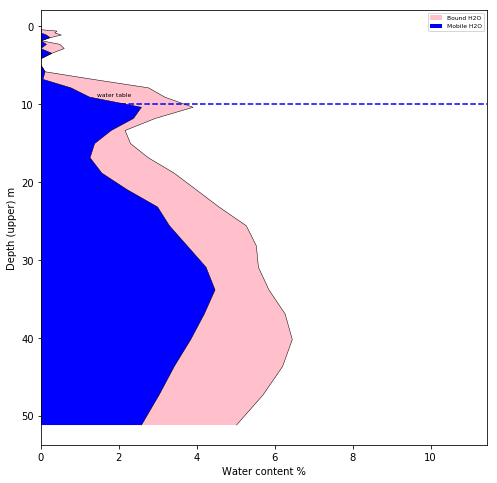

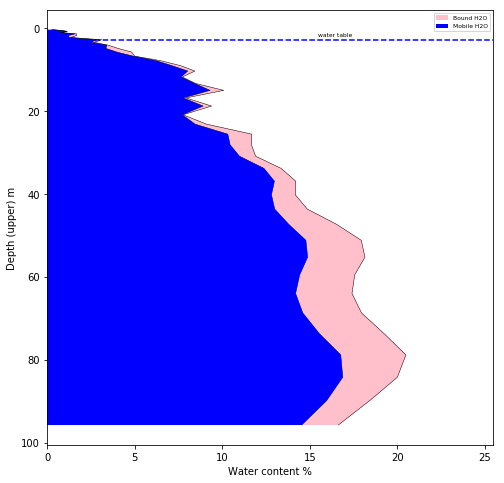

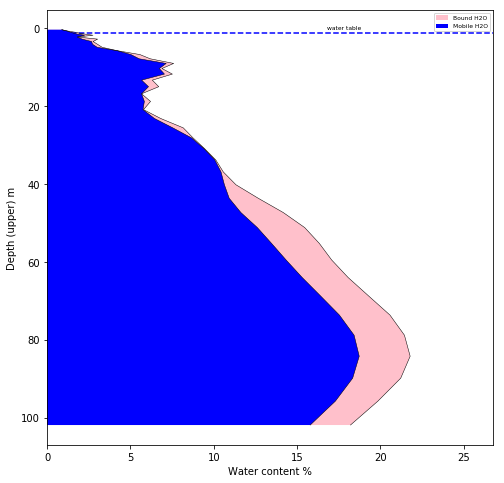

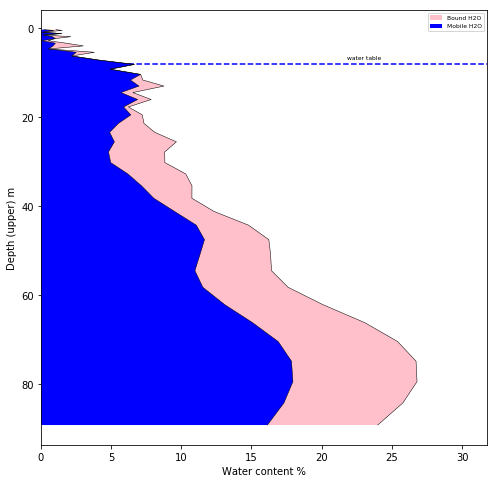

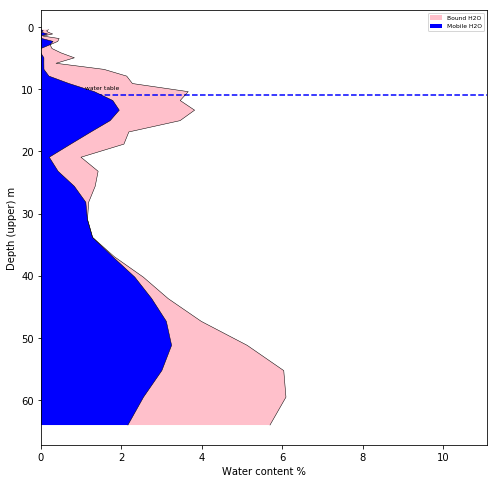

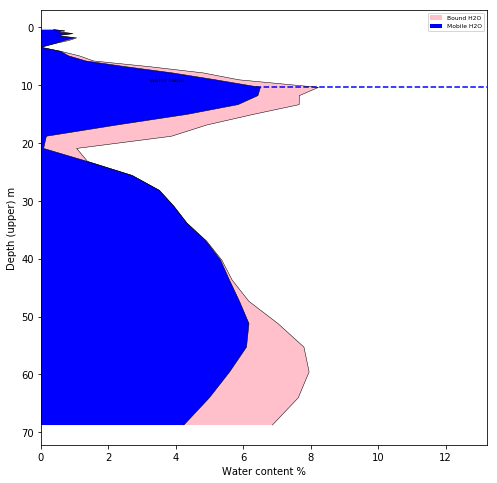

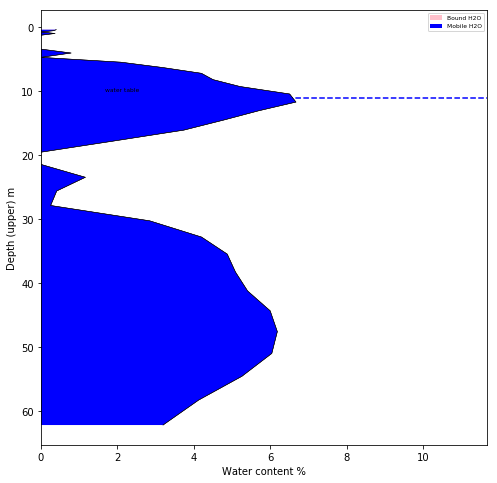

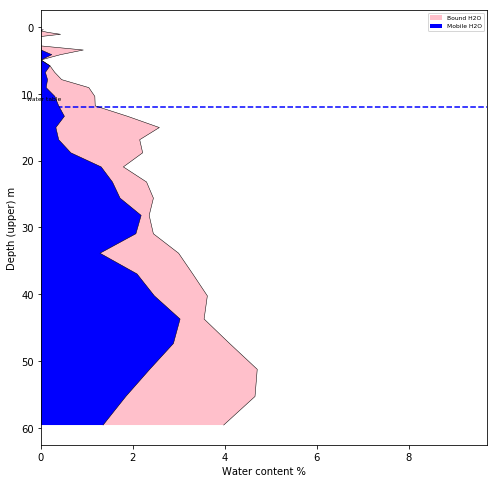

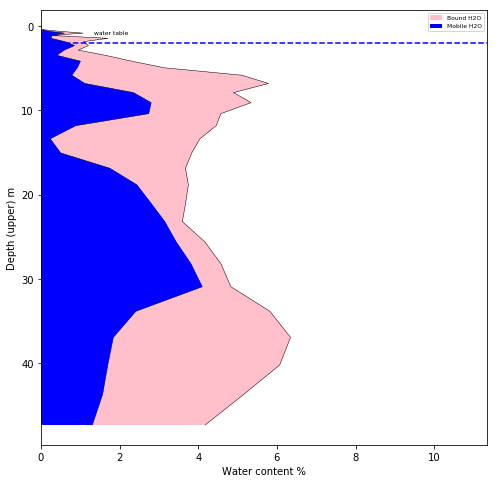

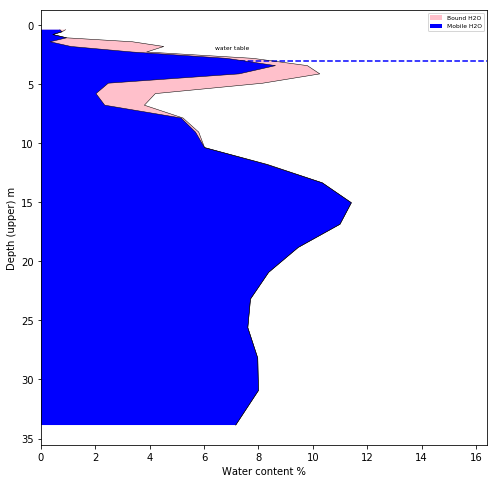

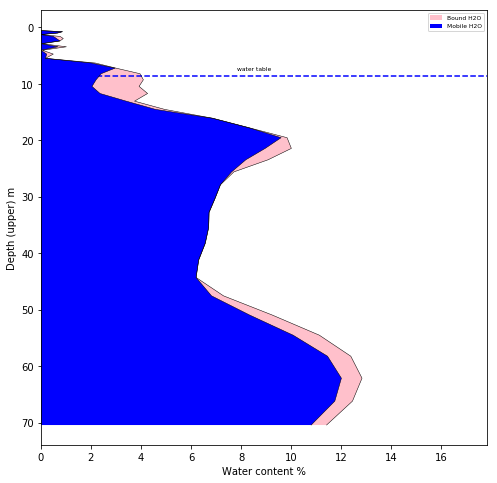

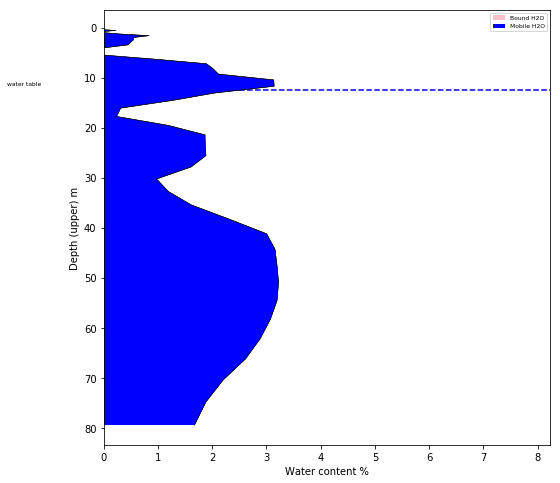

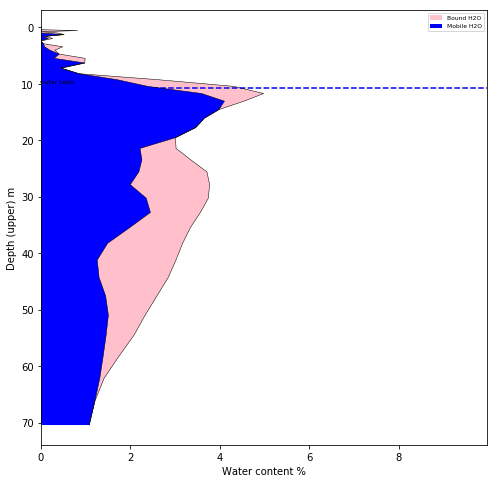

In [28]:
# For each bore with a standing water level plot
# the level on a plot of water level

mask = df_swl['co-located_SNMR_site_id'] != -999

df_swl_subset = df_swl[mask]

# Define outdir

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\KeepWaterTable\plots"


for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    # Create a plot
    fig, ax = plt.subplots(1,1,figsize = (8,8))
    
    # Add standing water level
    swl_depth = row['Depth']
    
    field_id = df_acquisitions[df_acquisitions['site_id'] == site_id]['Field_ID'].values[0]
    
    SNMR_utils.plot_profile(ax, SNMR_inversion, doi = None,
                           plot_mobile_water=True, water_table_depth = swl_depth)
    
    
    fname = row['Borehole_name'] + '_' + field_id + "_comparison_plot.png"
    
    
    plt.savefig(os.path.join(outdir, fname))
    
    
    

In [50]:
# NExt we iterate through ever SNMR site, get teh water table estimate from the kriging and plot it
combined_x_y_arrays = np.dstack([gridy.ravel(),gridx.ravel()])[0]

combined_x_y_arrays

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [30]:
# Calculate key attributes for the optimisation exercise

# Find the mean and standard deviation of a moving window for the mobile water

window_size = 6

metric = 'Total_water_content'

for index, row in df_swl_subset.iterrows():
    site_id = row['co-located_SNMR_site_id']
    # Extract inversion
    SNMR_inversion = df_inversions[df_inversions['site_id'] == site_id]
    
    a = SNMR_inversion[metric]
    
    # Get mean-zero water content
    SNMR_inversion[metric + '_zero_mean'] = a - np.mean(a)
    
    # Calculate the rolling mean
    rolling_mean = a.rolling(window_size, min_periods = 1).mean()
    rolling_std = a.rolling(window_size, min_periods = 1).std()
    # Coefficient of variation
    SNMR_inversion[metric + '_CV'] = np.divide(rolling_std, rolling_mean)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


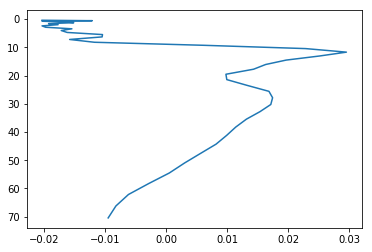

In [40]:
y,x1 = SNMR_inversion['Depth_from'].values, SNMR_inversion['Total_water_content_zero_mean'].values
x2 = SNMR_inversion['Total_water_content_CV'].values

plt.plot(x,y)
#plt.plot(x2,y)
plt.gca().invert_yaxis()

plt.show()

In [39]:
field_id

'KCP_nst1_s5'